# How to preprocess an image dataset for machine learning

** What is preprocessing? **  
Preprocessing describes the process of cleaning and converting a 'raw' (i.e. unprocessed) dataset into a clean dataset.

![alt text](figures/preprocessing.png)

When given a dataset, the preprocessing can have various steps depending on  
a) what type of data you're looking at (text, images, time series, ...)  
b) what models you want to train

In this notebook we will look at an **image dataset**.

** Possible preprocessing steps **

As mentioned already, the preprocessing steps you will need for your dataset depend on the nature of the dataset and models you want to train. Possible preprocessing steps for images are:

- Rescale the images
- Normalizing the pixel values
- Convert images to grayscale
- Perform data augmentation
- etc.

## The Oxford-IIIT Pet Dataset

The Oxford-IIIT Pet Dataset consist of 7349 images of different dog and cat breeds. The dataset and further information about its statistics are available [here](http://www.robots.ox.ac.uk/~vgg/data/pets/).

## Step 1: Download the dataset

You can dowload the dataset on [this website](http://www.robots.ox.ac.uk/~vgg/data/pets/) or simply run the following commands from the command line:

```bash
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
```

Next, go to the your 'Downloads' folder (or wherever the file was saved) and run

```bash
tar -xzf images.tar.gz -C name_of_destination_folder
```

For example, to unpack the folder in the current directory run

```bash
tar -xzf images.tar.gz -C .
```

## Step 2: Inspect the dataset

Let's take a look at some of the images to make sure that they have been downloaded correctly.

Several libraries exist that make it easier to preprocess images. For example, you can use [scikit-image](http://scikit-image.org/), [OpenCV](https://opencv.org/) or [Pillow](http://python-pillow.org/). Each library has different functionalities, pros and cons. In this notebook we will stick to scikit-image.


In [3]:
import glob
import os
import random
import matplotlib
import warnings

import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import img_as_float
from skimage.transform import resize, rotate
from skimage.color import rgb2gray

% matplotlib inline
warnings.simplefilter('ignore')

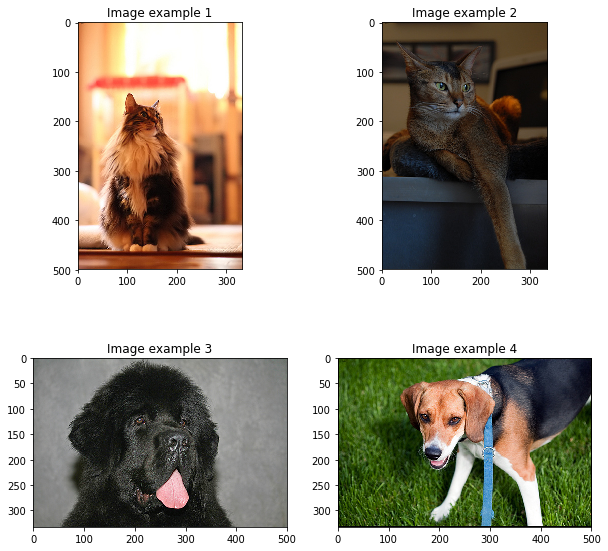

In [7]:
# Create a list of all images
root_path = os.path.expanduser('~/ml_basics/images/')
all_images = glob.glob(root_path + '/*.jpg')
# To avoid memory errors we will only use a subset of the images
all_images = random.sample(all_images, 500)

# Plot a few images
i = 0
fig = plt.figure(figsize=(10, 10))
for img_path in all_images[:4]:
    img_arr = io.imread(img_path)
    i += 1
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(img_arr)
    ax.set_title(f"Image example {i}")

## Important: Creating a test set

If you want to train a machine learning model on your data it's important that you create a separate test set BEFORE you do any further preprocessing. The test set is put aside and not looked at, it's sole purpose is to allow for an evaluation of the trained classifier.

We will skip this step since we are not training a classifier. However, you should not forget about creating a test set when you preprocess your own dataset!

## Step 3: Rescale the images

The images displayed above show us that the dataset has images with various scales. So, as a first preprocessing step, we will make sure that all images have the same height and width. When choosing an appropriate size we should keep in mind that bigger images correspond to higher computational requirements (both memory and operation wise).

As a first step we should figure out the dimensions of our images. 

In [8]:
all_sizes = [io.imread(img).shape for img in all_images]

heights = [img_shape[0] for img_shape in all_sizes]
widths = [img_shape[1] for img_shape in all_sizes]

print(f"Minimum image height: {min(heights)}")
print(f"Maximum image height: {max(heights)}")
print()
print(f"Minimum image width: {min(widths)}")
print(f"Maximum image width: {max(widths)}")

Minimum image height: 135
Maximum image height: 1200

Minimum image width: 119
Maximum image width: 1600


We will resize the images to $256 \times 256$ pixels using scikit-image (other shapes would be fine, too). The images won't be cropped but up-sized or down-sized using interpolation.

Further, for simplicity, we will skip images that have less or more than 3 color channels (i.e. images whose mode is not RGB). As a quick reminder:

**RGB** is a 3-channel format corresponding to the channels red, green and blue. **RGBA** is a 4-channel format corresponding to red, green, blue and alpha. The alpha channel makes the color of the image transparant or translucent.

Note: make sure to create a folder named "resized_images", otherwise the code below will raise an error!

In [9]:
resized_path = os.path.join(root_path, 'resized_images/')

for img_path in all_images:
    # Create a new image name to save the resized image
    img_name = img_path.split('/')[-1]
    img_name = os.path.splitext(img_name)
    resized_name = img_name[0] + '_resized' + img_name[1]
    save_path = os.path.join(resized_path, resized_name)
    
    img = io.imread(img_path)
    
    if img.ndim != 3 or img.shape[2] != 3:
        continue
    
    resized_img = resize(img, output_shape=(256, 256))    
    io.imsave(save_path, resized_img)

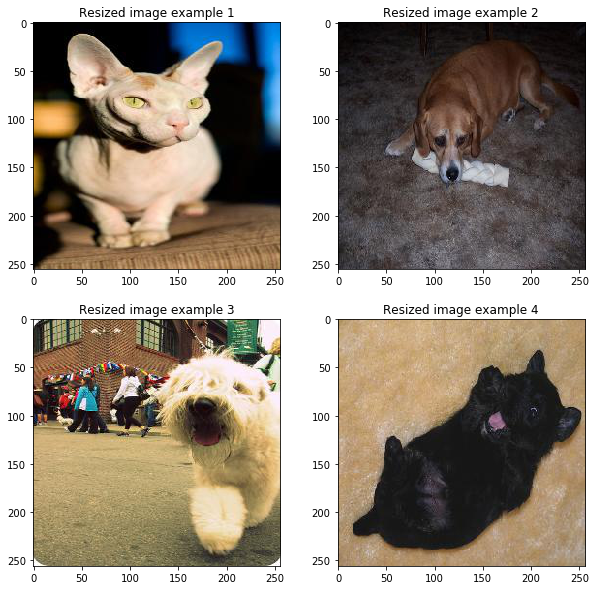

In [10]:
all_images = glob.glob(resized_path + '/*')

# Plot a few images
fig = plt.figure(figsize=(10, 10))

i = 0
for img_path in all_images[:4]:
    img_arr = io.imread(img_path)
    i += 1
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(img_arr)
    ax.set_title(f"Resized image example {i}")

## Step 3: Normalizing pixel values

When we want to train a neural network it can be useful to normalize the dataset. This is nicely explained in this [Stanford course](http://cs231n.github.io/neural-networks-2/). 

Normalizing pixel values has two steps:

1. *Mean subtraction:* in the case of images this often refers to subtracting the mean computed over *all* images from each pixel. The mean value can be computed over all three channels or for each channel individually. As described in the given link this has the "geometric interpretation of centering the cloud of data around the origin along every dimension".   
   
2. *Divide by standard deviation*: This step is not strictly necessary for images because the relative pixel scales are already approximately equal. Nevertheless, we will include this step for completeness.

Further explanation why normalization is useful can be found [here]( https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c).

In [11]:
# To compute the mean and standard deviation over all images
# we need to combine them in one big array
big_list = []

for img_path in all_images:
    big_list.append(io.imread(img_path))

all_imgs = np.array(big_list)

# The image pixels are uint8. To compute a mean we
# convert the pixel values to floats
all_imgs_float = img_as_float(all_imgs)

# Mean subtraction
mean = np.mean(all_imgs_float, axis=0)
all_imgs_float -= mean

# Dividing by standard deviation
std = np.std(all_imgs_float, axis=0)
all_imgs_float /= std

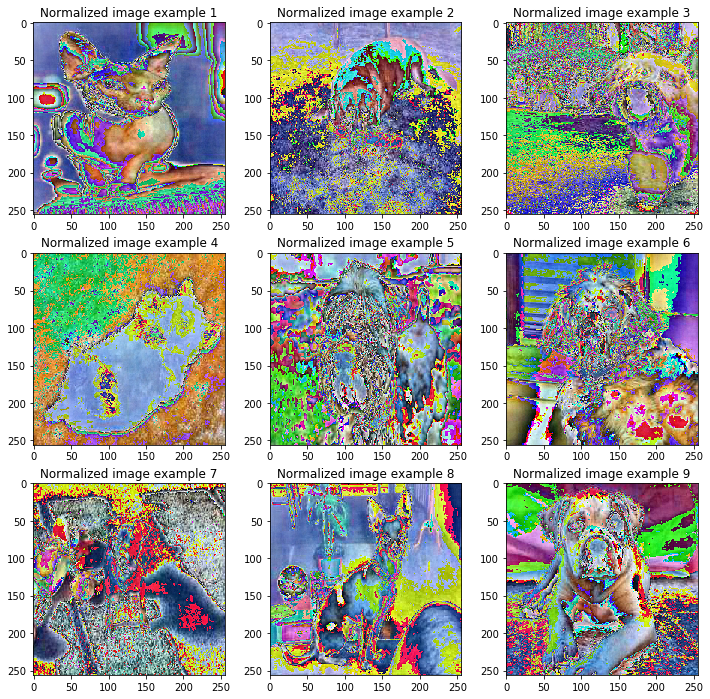

In [12]:
fig = plt.figure(figsize=(12, 12))

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(all_imgs_float[i])
    ax.set_title(f"Normalized image example {i+1}")

## Step 4: Converting to grayscale

Converting the images to grayscale is very easy with scikit-image.

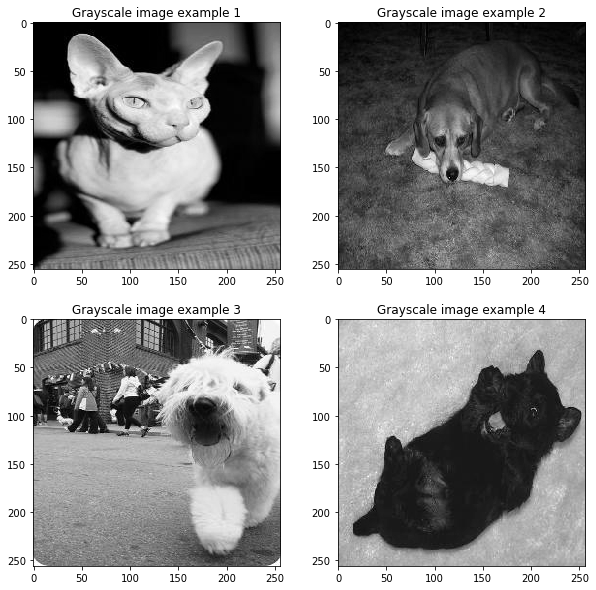

In [13]:
gray_images = rgb2gray(all_imgs)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(gray_images[i], cmap='gray')
    ax.set_title(f"Grayscale image example {i+1}")

## Step 5: Data augmentation

First of all: why do we need data augmentation?

The performance of a machine learning algorithm depends heavily on the amount and quality of the data it is trained with. In most cases, the more data a machine learning algorithm has access to, the more effective it can be. However, most of the time, we only have access to a small amount of data with sufficient quality. So, if we augment our dataset in a useful way we can improve the performance of our model without having to gather a larger dataset.   

Furthermore, augmenting the dataset can make our model more robust. For example, consider the task of image classification. Let's say we want to classify the breed of dog/cat shown in each image of our dataset. Our training set will contain only a limited amount of images each breed, and each breed will be displayed in a limited set of conditions. However, our test set (or real world application) may contain images of dogs and cats in a large variety of conditions. The images could be taken from various angles, locations, lighting conditions, etc. By augmenting our training set with small variations of the original images, we can allow our model to account for such variations.

Images can be augmented in various ways, for example using:
- rotation
- translation
- rescaling
- flipping
- stretching
etc.

Most of these tasks can be performed easily with scikit-image or one of the other image processing libraries. Let's look at **rotation** as an example.

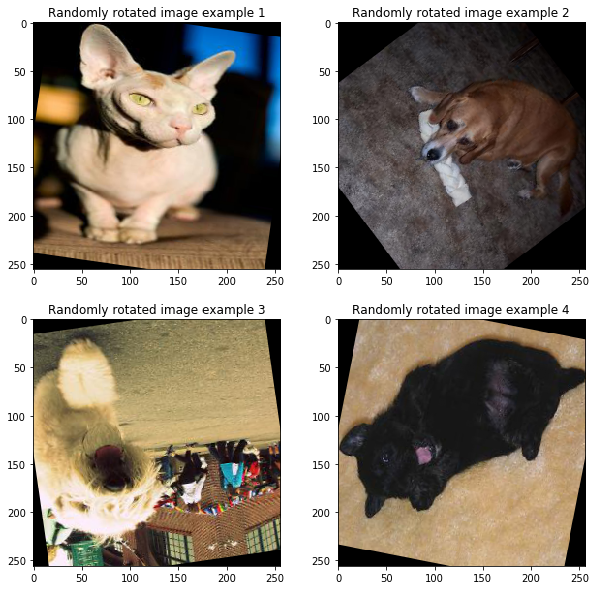

In [14]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    random_angle = np.random.randint(low=0, high=360)
    rotated_image = rotate(all_imgs[i], angle=random_angle)
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(rotated_image)
    ax.set_title(f"Randomly rotated image example {i+1}")